# Assignment 1 - Deep Learning
[Annalisa Paladino](mailto:ANNALISA.PALADINO@studenti.units.it)  

## Problem:

1.   Read carefully the paper [*“Learning representations by back-propagating errors” (Rumelhart et al., 1986)*](https://bucket.ballarin.cc/papers/oth/rumelhart1986.pdf). Read it in its entirety, but focus specifically on the experiment outlined in *Fig. 1* (learning mirror symmetries in 6-digits numbers).

2.   Reproduce in `PyTorch` (or any other *DL* library you are confident using) such experiment. Try to be as close as possible to the original protocol, with respect to network architecture, activation functions, learning algorithm and parameter initialization.

3.   Assess model accuracy, and inspect the weights of the trained network. Do they provide a solution to the problem?

4.   Compare the solution to the one reported in the original paper. Comment.

5.   **Optional:** you are warmly encouraged to explore and discuss additional variations to the experimental details and the results they produce on final accuracy and weights of the network. Some of such changes may include (but are not limited to):
     -   changing the activation functions of the network;
     -   changing the optimizer and/or its hyperparameters;
     -   adding a learning rate scheduler, *etc.*

Experiment in Fig1:

A network that has learned to detect mirror symmetry in the input vector. The numbers on the arcs are weights and the numbers inside the nodes are biases. The learning required $1$, $425$ sweeps through the set of $64$ possible input vectors, with the weights being adjusted on the basis of the accumulated gradient after each sweep. The values of the parameters in equation $\Delta w(t) = - \frac{\epsilon \partial E} {\partial w(t)} + \alpha \Delta w (t-1)$ were $\epsilon = 0.1$ and $\alpha = 0.9$. The initial weights were random and were uniformly distributed between $-0.3$ and $0.3$. The key property of this solution is that for a given hidden unit, weights that are symmetric about the middle of the input vector are equal in magnitude and opposite in sign. So if a symmetrical pattern is presented, both hidden units will receive a net input of 0 from the input units, and, because the hidden units have a negative bias, both will be off. In this case the output unit, having a positive bias, will be on. Note that the weights on each side of the midpoint are in the ratio $1:2:4$. This ensures that each of the eight patterns that can occur above the midpoint sends a unique activation sum to each hidden unit, so the only pattern below the midpoint that can exactly balance this sum is the symmetrical one. For all non-symmetrical patterns, both hidden units will receive non-zero activations from the input units. The two hidden units have identical patterns of weights but with opposite signs, so for every non-symmetric pattern one hidden unit will come on and suppress the output unit.

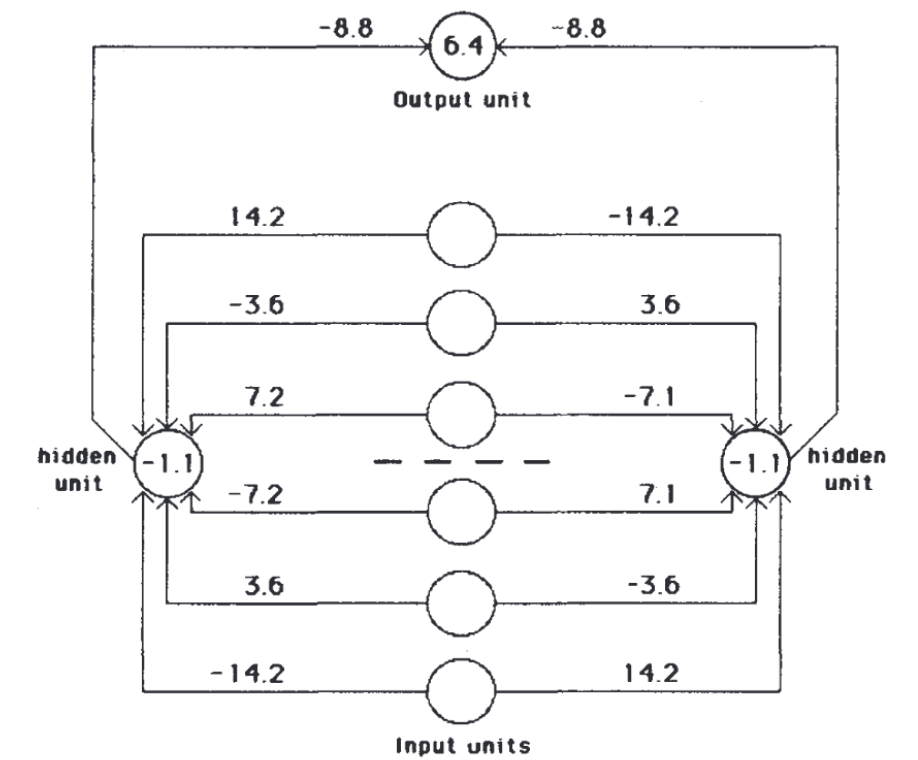

## Solution:

To begin, we can download the necessary libraries.

In [28]:
import torch
import torch.nn as nn
import numpy as np
from torch import Tensor
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from itertools import product
import matplotlib.pyplot as plt

### Create the dataset

Let's start by creating the dataset of this problem, it is composed of lists of 6 binary elements, in total there are 64 elements. 

In [29]:
# Create the dataset
def is_symmetric(binary_string):
    return float(binary_string == binary_string[::-1])

# All possible 6-bit binary numbers
inputs = torch.tensor([list(map(float, format(i, '06b'))) for i in range(64)], dtype=torch.float32)
# Target outputs for mirror symmetry
targets = torch.tensor([[is_symmetric(bin(i)[2:].zfill(6))] for i in range(64)], dtype=torch.float32)

# DataLoader
train_data = TensorDataset(inputs, targets)
train_loader = DataLoader(train_data, batch_size=64, shuffle=False)

### Define the network

The neural network is created as an instance of the `MirrorSymmetryNetwork` class which inherits from `nn.Module`. There are 2 layers:

- **Hidden Layer**: defined by `self.hidden = nn.Linear(6, 2, bias=True)`. This layer takes the input data, applies a linear transformation and outputs a tensor of size 2. 

- **Output Layer**: defined by `self.output = nn.Linear(2, 1, bias=True)`. This layer takes the output of the hidden layer, applies another linear transformation, and outputs a tensor of size 1. This final output is the prediction of the network.

`Sigmoid` is the **activation function**

In [30]:
# Define the network
class MirrorSymmetryNetwork(nn.Module):
    def __init__(self):
        super(MirrorSymmetryNetwork, self).__init__()
        # Define the network layers
        self.hidden = nn.Linear(6, 2, bias=True)
        self.output = nn.Linear(2, 1, bias=True)
        # Sigmoid activation function
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.sigmoid(self.hidden(x))
        x = self.sigmoid(self.output(x))
        return x

# Initialize the network
net = MirrorSymmetryNetwork()

The paper specifies that the initial weights were random and were uniformly distributed between $-0.3$ and $0.3$. 

The key property of this solution is that for a given hidden unit, weights that are symmetric about the middle of the input vector are equal in magnitude and opposite in sign.

In [31]:
# Initialize weights and biases within the range [-0.3, 0.3]
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.uniform_(m.weight, -0.3, 0.3)
        nn.init.uniform_(m.bias, -0.3, 0.3)

# Apply weight initialization
net.apply(init_weights)

MirrorSymmetryNetwork(
  (hidden): Linear(in_features=6, out_features=2, bias=True)
  (output): Linear(in_features=2, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

### Define loss & optimizer

Before starting with the training it's important to define the loss criterion, in this case I defined the one described in the paper. For the optimizer I decided to use SGD with learning rate 0.1 and momentum 0.9.

In [32]:
# Loss and optimizer
def lss(output, target):
        return torch.sum((output - target) ** 2)/2

optimizer = torch.optim.SGD(net.parameters(), lr=0.1, momentum=0.9)

### Training

Let's train our model now !

In [33]:
# Initialize lists to store loss and accuracy
losses = []
accuracies = []

# Training loop
for epoch in range(1425):
    for input_vector, target in train_loader:
        output = net(input_vector)
        loss = lss(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Record the loss
    losses.append(loss.item())
    
    # Calculate accuracy
    with torch.no_grad():
        predictions = net(inputs).round()
        accuracy = (predictions == targets).float().mean().item()
        accuracies.append(accuracy)

    if epoch % 100 == 0:
        print(f'Epoch {epoch}: Loss = {loss.item()}, Accuracy = {accuracy}')

Epoch 0: Loss = 7.883525848388672, Accuracy = 0.875
Epoch 100: Loss = 3.9999842643737793, Accuracy = 0.875
Epoch 200: Loss = 3.999983787536621, Accuracy = 0.875
Epoch 300: Loss = 3.999983787536621, Accuracy = 0.875
Epoch 400: Loss = 3.999983787536621, Accuracy = 0.875
Epoch 500: Loss = 3.999983787536621, Accuracy = 0.875
Epoch 600: Loss = 3.999983787536621, Accuracy = 0.875
Epoch 700: Loss = 3.999983310699463, Accuracy = 0.875
Epoch 800: Loss = 3.999983310699463, Accuracy = 0.875
Epoch 900: Loss = 3.999983310699463, Accuracy = 0.875
Epoch 1000: Loss = 3.9999828338623047, Accuracy = 0.875
Epoch 1100: Loss = 3.9999828338623047, Accuracy = 0.875
Epoch 1200: Loss = 3.9999828338623047, Accuracy = 0.875
Epoch 1300: Loss = 3.9999828338623047, Accuracy = 0.875
Epoch 1400: Loss = 3.9999825954437256, Accuracy = 0.875


In [34]:
with torch.no_grad():
    for param in net.parameters():
        print(param.detach().clone())

tensor([[ 0.0901,  0.2923, -0.2189, -0.0346,  0.2434, -0.0174],
        [ 0.3517,  0.4259,  0.4911,  0.5266,  0.3733,  0.1544]])
tensor([0.2533, 0.6439])
tensor([[-4.0130, -4.7982]])
tensor([-6.7603])


### Plots

Text(0.5, 1.0, 'Loss vs. Epoch')

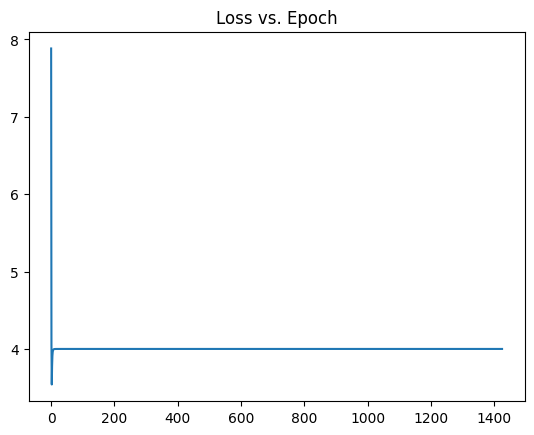

In [35]:
plt.plot(losses)
plt.title('Loss vs. Epoch')

Text(0.5, 1.0, 'Accuracy vs. Epoch')

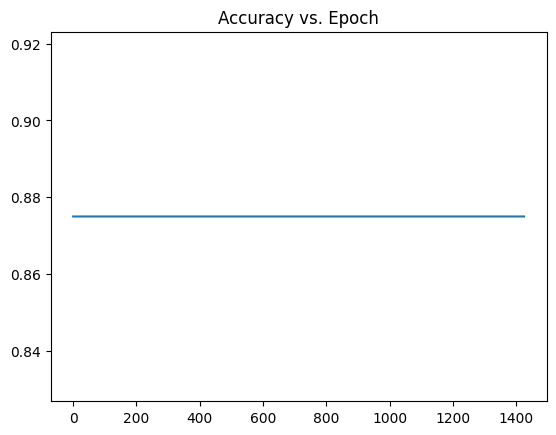

In [36]:
plt.plot(accuracies)
plt.title('Accuracy vs. Epoch')